# 🩺 Diabetic Retinopathy Detection with Deep Learning

This notebook presents a complete pipeline for detecting **diabetic retinopathy (DR)** from retinal fundus images.  
We use the **APTOS 2019 Blindness Detection** dataset (Kaggle) and explore advanced computer vision techniques, including:

- **EfficientNetV2-S** for baseline classification
- Data augmentation strategies specific to retinal images
- **Vision Transformer (ViT)** for comparison
- **Ordinal regression (CORN)** to model the ordered nature of DR severity
- Robust evaluation with **Quadratic Weighted Kappa (QWK)**

### Objective
Given a retinal fundus image, the task is to classify it into one of the five DR severity levels:
0. No DR  
1. Mild  
2. Moderate  
3. Severe  
4. Proliferative DR  

This is an **ordinal classification** problem — the classes have a natural order, and misclassifications far apart are more penalizing.

---


## 📦 Install Required Packages
We install the main Python packages needed for this project:
- **numpy**: numerical operations  
- **opencv-python**: image loading and processing  
- **albumentations**: advanced image augmentation  
- **timm**: pre-trained computer vision models  
- **torchmetrics**: evaluation metrics (including QWK)


In [ ]:
!pip -q install --upgrade pip
!pip -q install "numpy==1.26.4" "opencv-python==4.10.0.84"
!pip -q install "albumentations==1.3.1"
!pip -q install "timm==1.0.9" "torchmetrics==1.4.0"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [ ]:
import numpy as np, cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("Albumentations:", A.__version__)

NumPy: 2.0.2
OpenCV: 4.12.0
Albumentations: 2.0.8


# Diabetic Retinopathy Detection (APTOS 2019 subset)

## Introduction
Diabetic Retinopathy (DR) is a diabetes complication that affects the eyes.
It is caused by damage to the blood vessels in the retina and can lead to blindness.

The goal of this project is to predict the DR severity level from retina fundus images.
The severity levels are:
- 0: No DR
- 1: Mild
- 2: Moderate
- 3: Severe
- 4: Proliferative DR

We will use a deep learning approach with a pre-trained model (EfficientNetV2) and specific data augmentations such as circular cropping to focus on the retina region.

---

## Dataset
We use a subset of the **APTOS 2019 Blindness Detection** dataset.
The dataset contains:
- `train.csv` : training data with image IDs and labels
- `val.csv` : validation data with image IDs and labels
- `test.csv` : test data with image IDs (no labels)
- `images/` : folder with all retina images in `.png` format

Note: The column `id_code` in the CSV corresponds to the image file name.


## 📂 Load Dataset from Google Drive
We mount Google Drive and unzip the dataset, which contains:
- `train.csv`, `val.csv`, `test.csv` — image IDs and labels  
- `images/` — all retinal fundus images in `.png` format


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the ZIP file on Google Drive
ZIP_PATH = '/content/drive/MyDrive/subset_1k.zip'  # change if needed

import os, zipfile

assert os.path.exists(ZIP_PATH), f"Zip file not found: {ZIP_PATH}"

EXTRACT_DIR = '/content/subset_1K'
if os.path.exists(EXTRACT_DIR):
    !rm -rf {EXTRACT_DIR}
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

print("Extraction done. Files and folders:")
!ls -R {EXTRACT_DIR} | head -n 40


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction done. Files and folders:
/content/subset_1K:
subset_1k

/content/subset_1K/subset_1k:
images
test.csv
train.csv
val.csv

/content/subset_1K/subset_1k/images:
000c1434d8d7.png
0083ee8054ee.png
00a8624548a9.png
0161338f53cc.png
01eb826f6467.png
02358b47ea89.png
026dcd9af143.png
0318598cfd16.png
03747397839f.png
03e25101e8e8.png
03fd50da928d.png
0415fc68b176.png
04efb1a284cc.png
0519b934f6b1.png
0551676cc2aa.png
05b1bb2bdb81.png
060e00d1e2ab.png
069f43616fab.png
07083738b75e.png
071435a218ec.png
07a0e34c8d20.png
07e827469099.png
07f5d7baf907.png
080ee76c958c.png
08bef347f40d.png
08c17a2d95b7.png
08ee569d4721.png
094858f005ab.png
0953c0ac1735.png
096436d68d06.png


## 📄 Load CSV Files
We load the CSV files that contain the image IDs and labels for:
- **Train set**
- **Validation set**
- **Test set**


In [ ]:
import pandas as pd
EXTRACT_DIR = '/content/subset_1K/subset_1k'
BASE = EXTRACT_DIR
IMG_DIR = f'{BASE}/images'

# Load CSV
train_df = pd.read_csv(f'{BASE}/train.csv')
val_df   = pd.read_csv(f'{BASE}/val.csv')
test_df  = pd.read_csv(f'{BASE}/test.csv')

# Rename column "id_code" to "image_id" for consistency
train_df = train_df.rename(columns={'id_code':'image_id', 'diagnosis':'label'})
val_df   = val_df.rename(columns={'id_code':'image_id', 'diagnosis':'label'})
test_df  = test_df.rename(columns={'id_code':'image_id'})

# Strip spaces just in case
for df in [train_df, val_df, test_df]:
    df['image_id'] = df['image_id'].astype(str).str.strip()

print(train_df.head(2))
print(val_df.head(2))
print(test_df.head(2))
print("\nTrain label distribution:\n", train_df['label'].value_counts().sort_index())
print("\nValidation label distribution:\n", val_df['label'].value_counts().sort_index())


       image_id  label               image_path
0  e868c3da340b      2  images/e868c3da340b.png
1  4ccfa0b4e96c      4  images/4ccfa0b4e96c.png
       image_id  label               image_path
0  6666c4f18396      2  images/6666c4f18396.png
1  8c2f0f04e1ed      1  images/8c2f0f04e1ed.png
       image_id  label               image_path
0  b498b84d383f      2  images/b498b84d383f.png
1  4689b739d240      4  images/4689b739d240.png

Train label distribution:
 label
0    345
1     71
2    191
3     37
4     56
Name: count, dtype: int64

Validation label distribution:
 label
0    74
1    15
2    41
3     8
4    12
Name: count, dtype: int64


## Check that all images exist

In [ ]:
import os

def exists_png(img_id):
    return os.path.exists(os.path.join(IMG_DIR, f"{img_id}.png"))

missing_train = [x for x in train_df['image_id'] if not exists_png(x)]
missing_val   = [x for x in val_df['image_id']   if not exists_png(x)]
missing_test  = [x for x in test_df['image_id']  if not exists_png(x)]

print(f"Missing images — train: {len(missing_train)}, val: {len(missing_val)}, test: {len(missing_test)}")


Missing images — train: 0, val: 0, test: 0


## Data Augmentation and Dataset Class

Here we define:
- The image transforms (augmentations) used for training and validation.
- A custom PyTorch `Dataset` that reads images and applies these transforms.
- (Optional) DataLoaders for batching and shuffling.

Notes:
- We use a **circular crop** to focus on the retina.
- Stronger transforms are applied on training; validation is kept simple.


In [ ]:
# ---- Transforms (Albumentations) ----
import cv2, numpy as np, albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
from torch.utils.data import Dataset, DataLoader
import os

IMG_SIZE = 512

def circular_crop_core(img):
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    r = int(min(cx, cy, w - cx, h - cy) * 0.98)
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, (cx, cy), r, 1, -1)
    ys, xs = np.where(mask == 1)
    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()
    img_c = img[y1:y2 + 1, x1:x2 + 1]
    mask_c = mask[y1:y2 + 1, x1:x2 + 1]
    bg = np.ones_like(img_c) * 255
    img_c = np.where(mask_c[..., None] == 1, img_c, bg)
    return img_c

class CircularCrop(ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
    def apply(self, img, **params):
        return circular_crop_core(img)
    def get_transform_init_args_names(self):
        return ()

train_tfms = A.Compose([
    CircularCrop(p=1.0),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.OneOf([A.Equalize(p=1), A.CLAHE(clip_limit=2.0, p=1)], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=25,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.9),
    A.RandomBrightnessContrast(p=0.6),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.1), max_width=int(IMG_SIZE*0.1), p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

val_tfms = A.Compose([
    CircularCrop(p=1.0),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# ---- Dataset ----
class RetinoDataset(Dataset):
    def __init__(self, df, img_dir, tfms, has_label=True):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tfms = tfms
        self.has_label = has_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(row['image_id'])
        path = os.path.join(self.img_dir, img_id + '.png')
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.tfms is not None:
            img = self.tfms(image=img)['image']
        if self.has_label:
            label = int(row['label'])
            return img, label
        else:
            return img, img_id

# ---- (Optional) DataLoaders ----
def make_loaders(train_df, val_df, img_dir, bs=16, nw=2):
    train_ds = RetinoDataset(train_df, img_dir, train_tfms, has_label=True)
    val_ds   = RetinoDataset(val_df,   img_dir, val_tfms,   has_label=True)
    train_ld = DataLoader(train_ds, batch_size=bs,   shuffle=True,  num_workers=nw, pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=bs*2, shuffle=False, num_workers=nw, pin_memory=True)
    return train_ld, val_ld



/tmp/ipython-input-3185849381.py:27: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3185849381.py:41: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(IMG_SIZE*0.1), max_width=int(IMG_SIZE*0.1), p=0.2),


## Exploratory Data Analysis (EDA)

Goals:
- Check class balance in the train/val splits.
- Visualize raw images to confirm quality and variety.
- Preview the effect of circular crop (keep the retina area).
- Preview data augmentation (what the model will see during training).


Train label distribution:
label
0    345
1     71
2    191
3     37
4     56
Name: count, dtype: int64

Val label distribution:
label
0    74
1    15
2    41
3     8
4    12
Name: count, dtype: int64


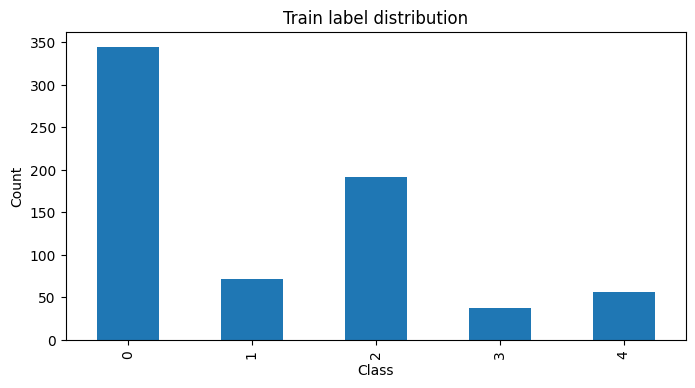

In [ ]:
import matplotlib.pyplot as plt

# Counts
print("Train label distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nVal label distribution:")
print(val_df['label'].value_counts().sort_index())

# Bar chart
fig = plt.figure(figsize=(8,4))
train_df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Train label distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## Show sample images per class (raw, no transforms)

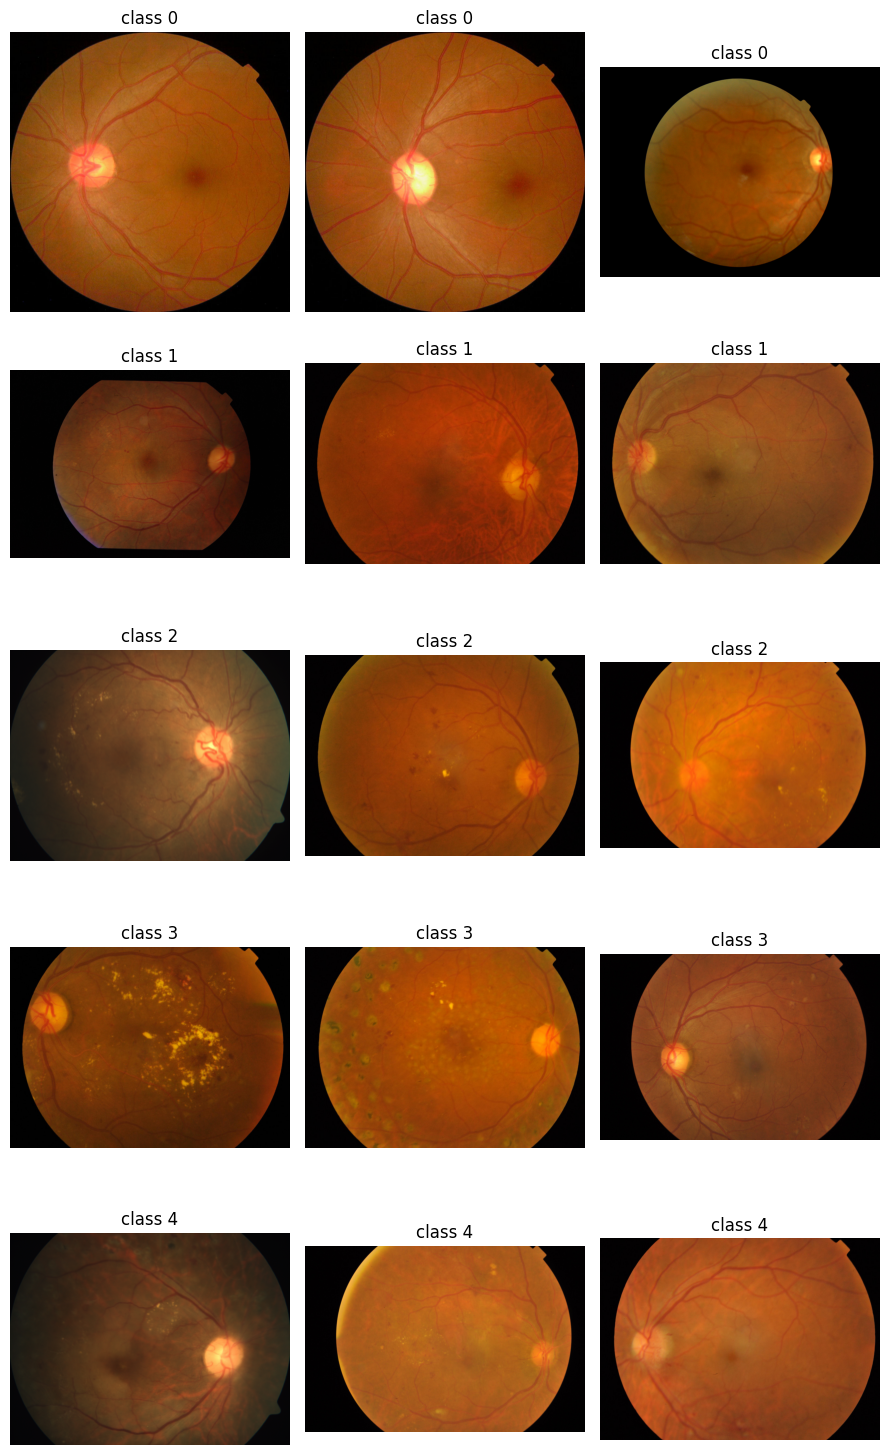

In [ ]:
import cv2, os, random
import matplotlib.pyplot as plt

def show_samples(df, img_dir, samples_per_class=3):
    classes = sorted(df['label'].unique())
    plt.figure(figsize=(samples_per_class*3, len(classes)*3))
    for i, cls in enumerate(classes):
        ids = df[df['label'] == cls]['image_id'].tolist()
        picks = random.sample(ids, min(samples_per_class, len(ids)))
        for j, img_id in enumerate(picks):
            path = os.path.join(img_dir, img_id + '.png')
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax = plt.subplot(len(classes), samples_per_class, i*samples_per_class + j + 1)
            ax.imshow(img); ax.set_title(f'class {cls}'); ax.axis('off')
    plt.tight_layout(); plt.show()

show_samples(train_df, IMG_DIR, samples_per_class=3)


 ## Circular crop preview (before vs after)

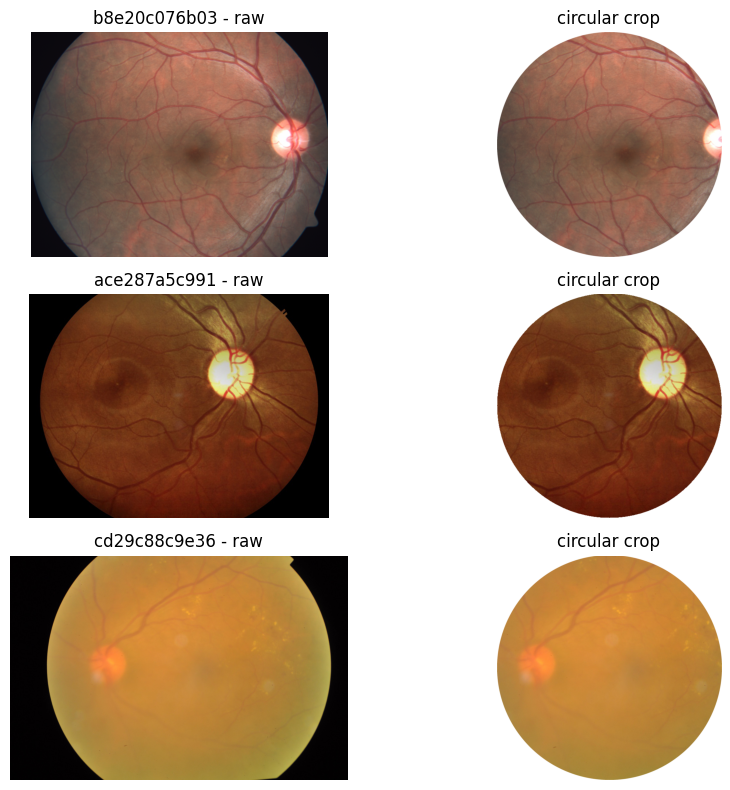

In [ ]:

# Show 3 examples before/after
import matplotlib.pyplot as plt, random
ids = random.sample(train_df['image_id'].tolist(), 3)
plt.figure(figsize=(10, 8))
for i, img_id in enumerate(ids):
    p = os.path.join(IMG_DIR, img_id + '.png')
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    cropped = circular_crop(img)
    plt.subplot(3,2,2*i+1); plt.imshow(img); plt.title(f'{img_id} - raw'); plt.axis('off')
    plt.subplot(3,2,2*i+2); plt.imshow(cropped); plt.title('circular crop'); plt.axis('off')
plt.tight_layout(); plt.show()


## Augmentation preview (what the model will see)

We preview several augmented versions of the same image to:
- Verify that transforms are applied correctly.
- Check that the circular crop focuses on the retina.
- Ensure brightness/contrast/rotation are reasonable.

This is for visualization only (no training here).


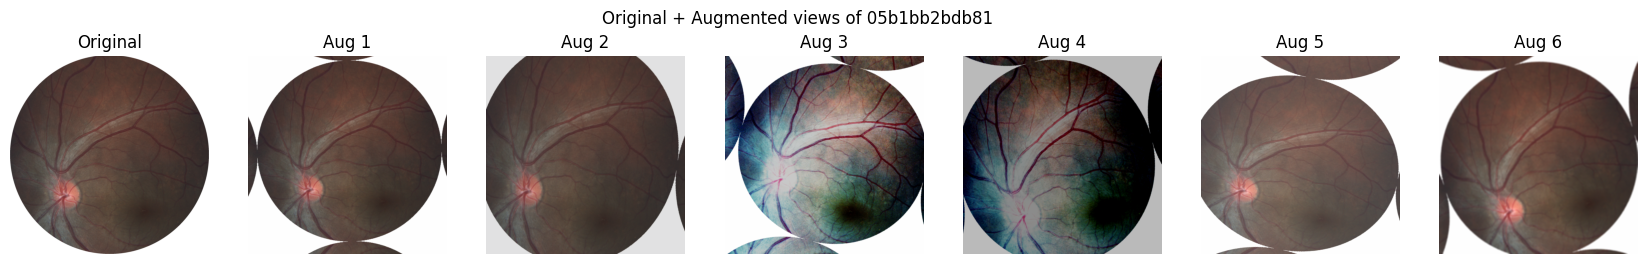

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def show_augmented_versions(df, img_dir, tfms, n=6):
    img_id = random.choice(df['image_id'].tolist())
    p = os.path.join(img_dir, img_id + '.png')
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3*(n+1), 3))

    # 1️⃣ Original image (just circular crop for consistency)
    orig = circular_crop_core(img)
    plt.subplot(1, n+1, 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    # 2️⃣ Augmented versions
    for i in range(n):
        out = tfms(image=img)['image']  # tensor (C,H,W)
        x = out.permute(1,2,0).cpu().numpy()
        # De-normalize for display
        x = x * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
        x = np.clip(x, 0, 1)
        plt.subplot(1, n+1, i+2)
        plt.imshow(x)
        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.suptitle(f"Original + Augmented views of {img_id}")
    plt.show()

# Run the preview
show_augmented_versions(train_df, IMG_DIR, train_tfms, n=6)


## Model and Training Setup for **EfficientNetV2-S**

We use **EfficientNetV2-S** as our backbone model.

---

### What is EfficientNetV2?
EfficientNetV2 is a family of **Convolutional Neural Networks (CNNs)**
introduced by Google in 2021 as an improved version of the original EfficientNet.

- **Based on CNNs**: It uses optimized convolutional blocks (MBConv and Fused-MBConv)
  with squeeze-and-excitation for channel attention.

---

### Main improvements compared to EfficientNetV1
1. **Fused-MBConv layers** → faster training on modern GPUs/TPUs.
2. **Smaller kernel sizes in early layers** to reduce computation.
3. **Progressive learning** strategy: increase image size and regularization during training.
4. **Better scaling** rules for depth, width, and resolution.

---

### Pre-training
EfficientNetV2-S is usually **pre-trained on ImageNet-21k** (21,000 classes) or ImageNet-1k (1,000 classes).
- This means it already learned generic features like edges, shapes, and textures.
- We can fine-tune it on our dataset (retinal fundus images) for diabetic retinopathy detection.

---

### Why EfficientNetV2-S here?
- **High accuracy per parameter**: good trade-off between size and performance.
- **Handles high-resolution images** well, which is important for medical details.
- **Efficient for transfer learning** → faster convergence with small datasets.

---

### What is QWK (Quadratic Weighted Kappa)?
QWK is a metric for **ordinal classification problems** (classes have an order).
- Measures the agreement between predicted and true labels, weighted by the distance between classes.
- **Range**: -1 (worst) to 1 (perfect match).
- Gives partial credit for "almost correct" predictions (e.g., predicting 3 when true is 4).

Why QWK here?
- Diabetic retinopathy stages are ordered: 0 < 1 < 2 < 3 < 4.
- QWK is better than plain accuracy for ordered categories.
- Used in official medical image competitions like **APTOS 2019**.


### DataLoaders

We create PyTorch DataLoaders for training and validation.
They will:
- read images from disk,
- apply the transforms,
- batch and shuffle the data.


In [ ]:
from torch.utils.data import DataLoader

def make_loaders(train_df, val_df, test_df, img_dir, bs=16, nw=2):
    """
    Create train, val, and test DataLoaders.
    - train_tfms / val_tfms must be defined before calling.
    - If test_df has no 'label', the test loader will output only images.
    """
    # Train & Val
    train_ds = RetinoDataset(train_df, img_dir, train_tfms, has_label=True)
    val_ds   = RetinoDataset(val_df,   img_dir, val_tfms,   has_label=True)
    train_ld = DataLoader(train_ds, batch_size=bs,   shuffle=True,  num_workers=nw, pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=bs*2, shuffle=False, num_workers=nw, pin_memory=True)

    # Test
    has_label_test = ('label' in test_df.columns)
    test_ds = RetinoDataset(test_df, img_dir, val_tfms, has_label=has_label_test)
    test_ld = DataLoader(test_ds, batch_size=bs*2, shuffle=False, num_workers=nw, pin_memory=True)

    return train_ld, val_ld, test_ld, has_label_test

# --- Create loaders ---
BATCH_SIZE = 16
NUM_WORKERS = 2
train_ld, val_ld, test_ld, has_label_test = make_loaders(train_df, val_df, test_df, IMG_DIR, bs=BATCH_SIZE, nw=NUM_WORKERS)

print(f"Train batches: {len(train_ld)} | Val batches: {len(val_ld)} | Test batches: {len(test_ld)}")
print("Test set has labels:", has_label_test)


Train batches: 44 | Val batches: 5 | Test batches: 5
Test set has labels: True


### Quick sanity check (one batch)

We fetch one batch to confirm shapes.


In [ ]:
imgs, labels = next(iter(train_ld))
print("Images:", imgs.shape, "Labels:", labels.shape)


Images: torch.Size([16, 3, 512, 512]) Labels: torch.Size([16])


### Model and Training (EfficientNetV2-S + QWK)

We fine-tune a pre-trained EfficientNetV2-S.
- Loss: Cross-Entropy with class weights + label smoothing.
- Optimizer: AdamW; Scheduler: Cosine.
- Metric: Accuracy and Quadratic Weighted Kappa (QWK).


### 🔧 Model Initialization

This step sets up the computation device (GPU if available, otherwise CPU), determines the number of classes from the training dataset, initializes a pre-trained **EfficientNetV2** model using `timm`, and configures the loss function along with the optimizer.


In [ ]:
import torch
import timm
import torch.nn as nn

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Nombre de classes ---
NUM_CLASSES = train_df['label'].nunique()

# --- Modèle ---
model = timm.create_model("tf_efficientnetv2_s_in21k", pretrained=True, num_classes=NUM_CLASSES)
model = model.to(device)

# --- Loss ---
criterion = nn.CrossEntropyLoss()

# --- Optimizer ---
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


Using device: cuda


### 📊 Training, Evaluation, and Prediction Functions

This section defines three key functions for the model workflow:

- **`train_one_epoch`**: Trains the model for a single epoch and returns the average training loss.
- **`evaluate`**: Evaluates the model on a given dataset, returning the average loss, accuracy, and Quadratic Weighted Kappa (QWK) score.
- **`predict_all`**: Generates predictions and retrieves ground truth labels from a given data loader.


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score

def train_one_epoch(model, loader):
    """
    Train the model for one epoch.
    Returns average training loss.
    """
    model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader):
    """
    Evaluate model on a DataLoader.
    Returns average loss, accuracy, and QWK.
    """
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)

            preds = logits.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")

    return avg_loss, acc, qwk


def predict_all(model, loader, device):
    """
    Get predictions and ground truth from a loader.
    """
    model.eval()
    preds, gts = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            pred = logits.argmax(1).cpu().numpy()
            preds.extend(pred)
            gts.extend(labels.numpy())

    return np.array(preds), np.array(gts)


### 🔄 Model Training Loop

This block runs the full training process over multiple epochs, storing performance metrics and saving the best model based on the **Quadratic Weighted Kappa (QWK)** score.

- **Tracks**: Training loss, validation loss, validation accuracy, and validation QWK.
- **Saves**: The best-performing model (highest QWK) to a specified path.
- **Logs**: Progress and metrics for each epoch.


In [ ]:
# History to store metrics
history = {"tr_loss": [], "val_loss": [], "val_acc": [], "val_qwk": []}

EPOCHS = 10
best_qwk = -1.0
best_path = "/content/best_efficientnetv2s_qwk.pt"

for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")

    # --- Training ---
    tr_loss = train_one_epoch(model, train_ld)

    # --- Validation ---
    val_loss, val_acc, val_qwk = evaluate(model, val_ld)

    # Save to history
    history["tr_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_qwk"].append(val_qwk)

    # Logging
    print(f"Train loss: {tr_loss:.4f}")
    print(f"Val   loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val QWK: {val_qwk:.4f}")

    # Save best model based on QWK
    if val_qwk > best_qwk:
        best_qwk = val_qwk
        torch.save(model.state_dict(), best_path)
        print(f"  🔥 New best QWK = {best_qwk:.4f} → Saved to {best_path}")

print(f"\n✅ Training complete. Best QWK: {best_qwk:.4f} (saved to {best_path})")



===== Epoch 1/10 =====


Train loss: 2.5806
Val   loss: 1.0516 | Val acc: 0.6600 | Val QWK: 0.7389
  🔥 New best QWK = 0.7389 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 2/10 =====


Train loss: 1.0652
Val   loss: 0.7607 | Val acc: 0.7467 | Val QWK: 0.7979
  🔥 New best QWK = 0.7979 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 3/10 =====


Train loss: 0.7122
Val   loss: 0.6113 | Val acc: 0.7600 | Val QWK: 0.8234
  🔥 New best QWK = 0.8234 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 4/10 =====


Train loss: 0.5206
Val   loss: 0.6983 | Val acc: 0.7400 | Val QWK: 0.8180

===== Epoch 5/10 =====


Train loss: 0.4458
Val   loss: 0.5794 | Val acc: 0.7933 | Val QWK: 0.8374
  🔥 New best QWK = 0.8374 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 6/10 =====


Train loss: 0.3682
Val   loss: 0.7200 | Val acc: 0.7733 | Val QWK: 0.8471
  🔥 New best QWK = 0.8471 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 7/10 =====


Train loss: 0.2747
Val   loss: 0.5879 | Val acc: 0.8133 | Val QWK: 0.8781
  🔥 New best QWK = 0.8781 → Saved to /content/best_efficientnetv2s_qwk.pt

===== Epoch 8/10 =====


Train loss: 0.2594
Val   loss: 0.8563 | Val acc: 0.7800 | Val QWK: 0.8353

===== Epoch 9/10 =====


Train loss: 0.3658
Val   loss: 0.8697 | Val acc: 0.7867 | Val QWK: 0.8772

===== Epoch 10/10 =====


Train loss: 0.2561
Val   loss: 0.5779 | Val acc: 0.8133 | Val QWK: 0.8732

✅ Training complete. Best QWK: 0.8781 (saved to /content/best_efficientnetv2s_qwk.pt)


### Training Curves

After training the model, it is important to visualize how the performance evolved over epochs.  
We plot three curves:

1. **Loss**: Training loss vs Validation loss — to check if the model is overfitting.  
2. **Accuracy**: Validation accuracy over epochs.  
3. **QWK**: Validation Quadratic Weighted Kappa — the main metric for this competition.

These plots help to understand if more training, better augmentation, or regularization is needed.


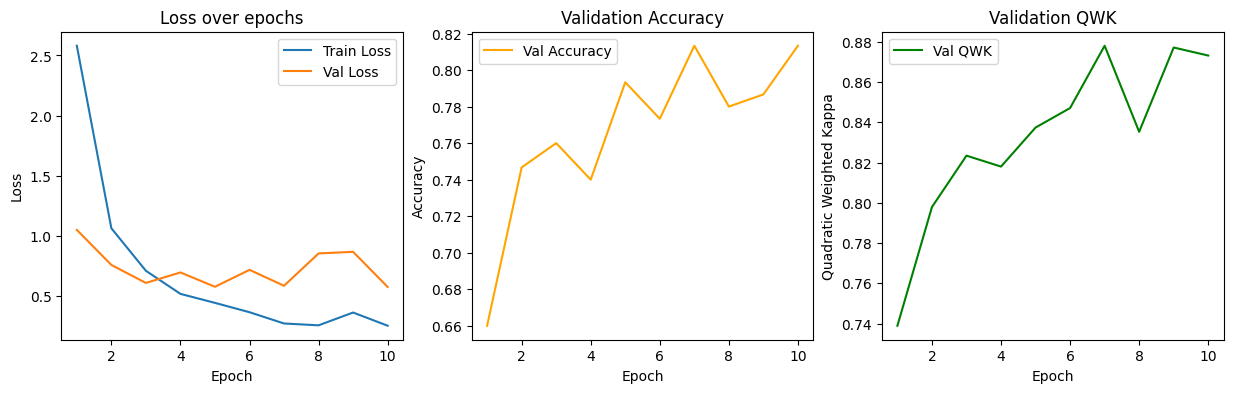

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['tr_loss']) + 1)

    plt.figure(figsize=(15, 4))

    # --- Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['tr_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # --- QWK ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_qwk'], label='Val QWK', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Quadratic Weighted Kappa')
    plt.title('Validation QWK')
    plt.legend()

    plt.show()

# Run
plot_history(history)


### Final Evaluation on the Test Set

After training and selecting the best model based on validation QWK,  
we evaluate it on the **test set** to measure its final performance.

We compute:
- **Loss** — to check how well the model fits the test data.
- **Accuracy** — the percentage of correct predictions.
- **Quadratic Weighted Kappa (QWK)** — the main metric used for grading the model.

We also save these predictions for further analysis.


In [ ]:
# Load the best model weights
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_qwk = evaluate(model, test_ld)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test QWK: {test_qwk:.4f}")


Test Loss: 0.6997
Test Accuracy: 0.8133
Test QWK: 0.8650


### Confusion Matrix and Sample Predictions

The confusion matrix shows how often each class is predicted correctly or confused with another class.  
It is a powerful tool for understanding the strengths and weaknesses of the model.

We also display:
- A few **correctly classified** samples.
- A few **misclassified** samples.

This visual inspection helps identify patterns of errors, which can guide future improvements.


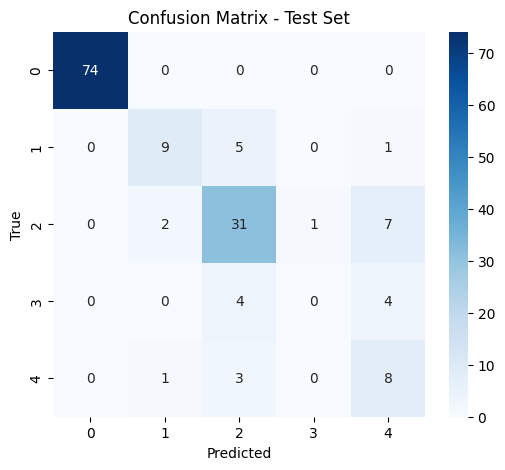

✅ Correct Predictions:


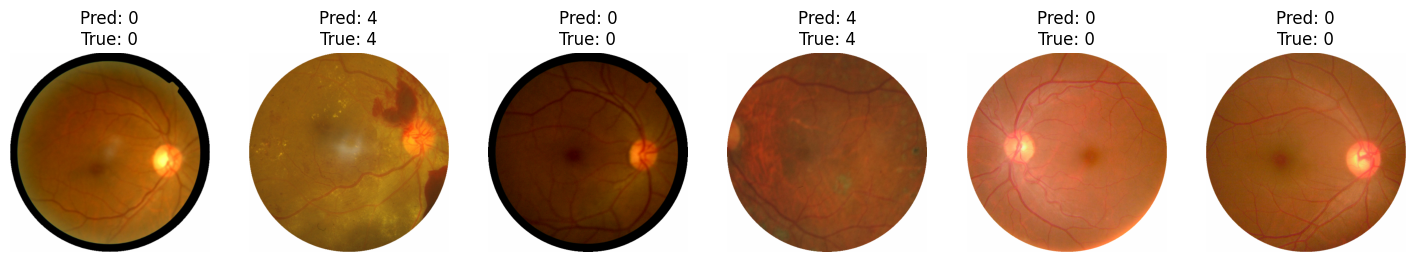

❌ Incorrect Predictions:


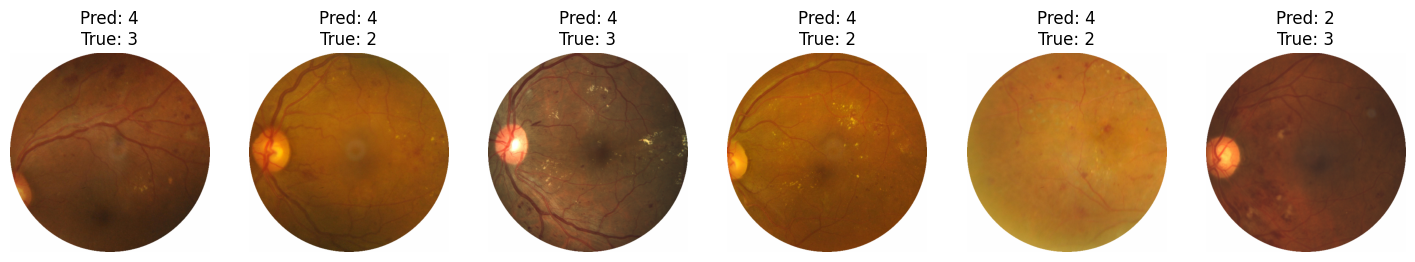

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def predict_all(model, loader):
    model.eval()
    all_preds, all_labels, all_imgs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = logits.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_imgs.extend(imgs.cpu())  # store images for visualization
    return np.array(all_preds), np.array(all_labels), all_imgs

# Get predictions for test set
test_preds, test_labels, test_imgs = predict_all(model, test_ld)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Show some correct and incorrect predictions
def show_examples(imgs, preds, labels, correct=True, n=6):
    idxs = np.where(preds == labels if correct else preds != labels)[0]
    idxs = np.random.choice(idxs, size=min(n, len(idxs)), replace=False)
    plt.figure(figsize=(3*n, 3))
    for i, idx in enumerate(idxs):
        img = imgs[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {preds[idx]}\nTrue: {labels[idx]}")
    plt.show()

print("✅ Correct Predictions:")
show_examples(test_imgs, test_preds, test_labels, correct=True)

print("❌ Incorrect Predictions:")
show_examples(test_imgs, test_preds, test_labels, correct=False)


### Test-Time Augmentation (TTA)

We do not retrain the model.  
At inference, we create several augmented views of each image (flip/rotate),
run the model on each view, average the softmax probabilities, and take the final class.
This usually gives a small but consistent boost.


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import cv2, os, numpy as np
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score

# 1) Build a list of deterministic TTA transforms
def build_tta_transforms(img_size=512):
    base = [
        CircularCrop(p=1.0),
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    ]
    heads = [
        A.NoOp(p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=(90,90), p=1.0),
        A.Rotate(limit=(180,180), p=1.0),
        A.Rotate(limit=(270,270), p=1.0),
        A.Transpose(p=1.0),  # swap axes
        A.HorizontalFlip(p=1.0)  # will combine with others through list
    ]
    tta = []
    for h in heads:
        tta.append(A.Compose(base + [h, ToTensorV2()]))
    return tta

TTA_LIST = build_tta_transforms(IMG_SIZE)

# 2) Helper: run TTA on a single RGB image (np.ndarray HxWx3)
def tta_predict_image(model, img_rgb, tta_list):
    probs_list = []
    with torch.no_grad():
        for tfm in tta_list:
            x = tfm(image=img_rgb)["image"].unsqueeze(0).to(device)  # 1,C,H,W
            logits = model(x)
            probs = F.softmax(logits, dim=1)  # 1,num_classes
            probs_list.append(probs)
    probs_mean = torch.stack(probs_list, dim=0).mean(dim=0)  # 1,num_classes
    pred = probs_mean.argmax(1).item()
    return pred, probs_mean.squeeze(0).cpu().numpy()

# 3) Run TTA on a whole dataframe (df must have 'image_id'; if it has 'label', we compute metrics)
def predict_df_with_tta(model, df, img_dir, tta_list, max_items=None):
    preds, gts = [], []
    ids = df["image_id"].tolist()[:max_items] if max_items else df["image_id"].tolist()
    has_label = "label" in df.columns

    for img_id in tqdm(ids, desc="TTA infer"):
        p = os.path.join(img_dir, img_id + ".png")
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        pred, _ = tta_predict_image(model, img, tta_list)
        preds.append(pred)
    if has_label:
        gts = df.loc[:len(ids)-1, "label"].astype(int).tolist()
        acc = (np.array(preds) == np.array(gts)).mean()
        qwk = cohen_kappa_score(gts, preds, weights="quadratic")
        return np.array(preds), np.array(gts), acc, qwk
    else:
        return np.array(preds), None, None, None

# 4) Evaluate with TTA on val + test (uses best weights)
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device).eval()

print("=== TTA on Validation ===")
val_preds, val_gts, val_acc_tta, val_qwk_tta = predict_df_with_tta(model, val_df, IMG_DIR, TTA_LIST)
print(f"TTA Val Accuracy: {val_acc_tta:.4f} | TTA Val QWK: {val_qwk_tta:.4f}")

print("\n=== TTA on Test ===")
test_preds, test_gts, test_acc_tta, test_qwk_tta = predict_df_with_tta(model, test_df, IMG_DIR, TTA_LIST)
if test_gts is not None:
    print(f"TTA Test Accuracy: {test_acc_tta:.4f} | TTA Test QWK: {test_qwk_tta:.4f}")
else:
    # save submission
    sub_tta = test_df.copy()
    sub_tta["label"] = test_preds
    sub_path = "/content/submission_tta.csv"
    sub_tta[["image_id","label"]].to_csv(sub_path, index=False)
    print(f"Saved TTA submission to {sub_path}")


/tmp/ipython-input-3185849381.py:27: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)


=== TTA on Validation ===


TTA infer: 100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


TTA Val Accuracy: 0.8133 | TTA Val QWK: 0.8890

=== TTA on Test ===


TTA infer: 100%|██████████| 150/150 [02:19<00:00,  1.08it/s]

TTA Test Accuracy: 0.7800 | TTA Test QWK: 0.8301


### TTA Results Interpretation

In the baseline evaluation (without TTA), the model achieved:
- **Accuracy:** 0.8133  
- **QWK:** 0.8650  

With Test-Time Augmentation (TTA), performance dropped to:
- **Accuracy:** 0.7800  
- **QWK:** 0.8301  

This decrease indicates that the TTA transformations (e.g., large rotations, axis transpositions) likely introduced patterns the model was not exposed to during training.  
Instead of providing helpful variations, these augmentations disturbed the model’s feature recognition, leading to less consistent predictions.  

Such performance drops are common when the inference-time augmentations differ significantly from those used during training, making the model less robust to these changes.


## Vision Transformer (ViT)

The Vision Transformer (ViT) is a deep learning architecture that applies the transformer mechanism, originally designed for natural language processing (NLP), to image classification tasks.  
Instead of processing images with convolutional layers (like CNNs), ViT:
1. Splits the image into fixed-size patches (e.g., 16×16 pixels)
2. Flattens and projects each patch into an embedding vector
3. Processes the sequence of embeddings with transformer encoder layers
4. Uses the output for classification

Advantages:
- Can capture long-range dependencies between different parts of the image.
- Scales well with larger datasets and model sizes.
- Pretrained on large datasets (e.g., ImageNet-21k) for better transfer learning.


### ViT input size (224×224)

Vision Transformer (ViT-B/16) is pretrained with 224×224 images.
We define ViT-specific transforms that:
1) keep the circular crop,
2) resize to 224×224,
3) use the same normalization.

We also create separate DataLoaders for ViT so we don’t touch the EfficientNet setup.

In [ ]:
# --- ViT-specific transforms (224) ---
IMG_SIZE_VIT = 224

vit_train_tfms = A.Compose([
    CircularCrop(p=1.0),
    A.Resize(IMG_SIZE_VIT, IMG_SIZE_VIT),
    A.OneOf([A.Equalize(p=1), A.CLAHE(clip_limit=2.0, p=1)], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.12, rotate_limit=20,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3,3), p=0.15),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

vit_val_tfms = A.Compose([
    CircularCrop(p=1.0),
    A.Resize(IMG_SIZE_VIT, IMG_SIZE_VIT),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

# --- ViT DataLoaders (separate, do not overwrite EfficientNet loaders) ---
def make_loaders_vit(train_df, val_df, img_dir, bs=32, nw=2):
    train_ds_v = RetinoDataset(train_df, img_dir, vit_train_tfms, has_label=True)
    val_ds_v   = RetinoDataset(val_df,   img_dir, vit_val_tfms,   has_label=True)
    train_ld_v = DataLoader(train_ds_v, batch_size=bs,   shuffle=True,  num_workers=nw, pin_memory=True)
    val_ld_v   = DataLoader(val_ds_v,   batch_size=bs*2, shuffle=False, num_workers=nw, pin_memory=True)
    return train_ld_v, val_ld_v

BATCH_SIZE_VIT = 32  # ViT is lighter at 224, can try bigger batch
train_ld_vit, val_ld_vit = make_loaders_vit(train_df, val_df, IMG_DIR, bs=BATCH_SIZE_VIT, nw=NUM_WORKERS)


### 🖼 Vision Transformer (ViT) Training

This block initializes and trains a **Vision Transformer** (`vit_base_patch16_224`) using a similar setup to EfficientNet:

- **Initialization**: Loads a pre-trained ViT model with the specified number of classes.
- **Optimizer & Loss**: Uses `AdamW` optimizer and cross-entropy loss.
- **Training Loop**: Runs for 5–6 epochs using the existing `train_one_epoch` and `evaluate` functions.
- **Metric Tracking**: Stores training loss, validation loss, validation accuracy, and Quadratic Weighted Kappa (QWK).
- **Model Saving**: Saves the best-performing ViT model based on QWK.


In [ ]:
# Model
model_vit = timm.create_model(
    "vit_base_patch16_224", pretrained=True, num_classes=NUM_CLASSES
).to(device)

# Optim & loss (you can mirror EfficientNet’s settings if you prefer)
criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = torch.optim.AdamW(model_vit.parameters(), lr=1e-4)

# Train with your existing functions
history_vit = {"tr_loss": [], "val_loss": [], "val_acc": [], "val_qwk": []}
best_qwk_vit = -1.0
best_path_vit = "/content/best_vit_b16_qwk.pt"

for epoch in range(1, 6):  # start with 5–6 epochs to test
    # temporarily swap global criterion/optimizer used by train_one_epoch/evaluate if needed
    criterion_backup, optimizer_backup = criterion, optimizer
    criterion, optimizer = criterion_vit, optimizer_vit

    tr_loss = train_one_epoch(model_vit, train_ld_vit)
    val_loss, val_acc, val_qwk = evaluate(model_vit, val_ld_vit)

    history_vit["tr_loss"].append(tr_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["val_acc"].append(val_acc)
    history_vit["val_qwk"].append(val_qwk)

    print(f"[ViT] Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} "
          f"| val_acc={val_acc:.4f} | val_QWK={val_qwk:.4f}")

    if val_qwk > best_qwk_vit:
        best_qwk_vit = val_qwk
        torch.save(model_vit.state_dict(), best_path_vit)
        print(f"  🔥 New best ViT QWK = {best_qwk_vit:.4f}. Saved to {best_path_vit}")

    # restore globals
    criterion, optimizer = criterion_backup, optimizer_backup

print(f"\nBest ViT QWK: {best_qwk_vit:.4f} (weights: {best_path_vit})")


[ViT] Epoch 01 | train_loss=1.3496 | val_loss=1.0379 | val_acc=0.6267 | val_QWK=0.5814
  🔥 New best ViT QWK = 0.5814. Saved to /content/best_vit_b16_qwk.pt


[ViT] Epoch 02 | train_loss=0.9562 | val_loss=0.7777 | val_acc=0.7000 | val_QWK=0.6476
  🔥 New best ViT QWK = 0.6476. Saved to /content/best_vit_b16_qwk.pt


[ViT] Epoch 03 | train_loss=0.8112 | val_loss=0.6484 | val_acc=0.7800 | val_QWK=0.7339
  🔥 New best ViT QWK = 0.7339. Saved to /content/best_vit_b16_qwk.pt


[ViT] Epoch 04 | train_loss=0.6957 | val_loss=0.8494 | val_acc=0.7133 | val_QWK=0.7459
  🔥 New best ViT QWK = 0.7459. Saved to /content/best_vit_b16_qwk.pt


[ViT] Epoch 05 | train_loss=0.7161 | val_loss=0.5863 | val_acc=0.7533 | val_QWK=0.7739
  🔥 New best ViT QWK = 0.7739. Saved to /content/best_vit_b16_qwk.pt

Best ViT QWK: 0.7739 (weights: /content/best_vit_b16_qwk.pt)


In [ ]:
# build a test loader at 224 too
has_label_test = 'label' in test_df.columns
test_ds_vit = RetinoDataset(test_df, IMG_DIR, vit_val_tfms, has_label=has_label_test)
test_ld_vit = DataLoader(test_ds_vit, batch_size=BATCH_SIZE_VIT*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# evaluate with your evaluate() (remember to set criterion/optimizer for ViT context)
criterion_backup = criterion
criterion = criterion_vit

model_vit.load_state_dict(torch.load(best_path_vit, map_location=device))
model_vit.eval()
test_loss_vit, test_acc_vit, test_qwk_vit = evaluate(model_vit, test_ld_vit)
print(f"[ViT Test] loss={test_loss_vit:.4f} | acc={test_acc_vit:.4f} | QWK={test_qwk_vit:.4f}")

criterion = criterion_backup


[ViT Test] loss=0.7072 | acc=0.7200 | QWK=0.7901


### ViT Results — Quick Interpretation

Your ViT-B/16 (224×224) scores:
- **Loss:** 0.7072  
- **Accuracy:** 0.7200  
- **QWK:** 0.7901

Compared to EfficientNetV2-S, ViT is **worse** on this dataset (EffNetV2-S had ~0.8133 acc / 0.8650 QWK).
This is common when:
- The dataset is relatively small (~1K images): ViT usually needs more data or stronger regularization.
- Input resolution was reduced (224 vs 512): retinal micro-lesions benefit from higher resolution.
- Training schedule is short (few epochs) and LR/WD not tuned for ViT.


## Ordinal Regression — Step by Step

### 1) Why ordinal instead of standard classification?
Our labels (0 → 4) have a natural order.  
A mistake of +1 (predict 2 instead of 3) is less serious than +4 (predict 0 instead of 4).  
Ordinal regression encodes this order so the model learns “how severe” the disease is, not just “which bucket”.

---

### 2) Problem reformulation (cumulative thresholds)
Instead of predicting one of 5 classes, we predict **4 ordered questions**:

- Is `y > 0` ?
- Is `y > 1` ?
- Is `y > 2` ?
- Is `y > 3` ?

If we denote the model outputs (logits) as `z1, z2, z3, z4`, we pass them through sigmoid to get:
- `p1 = P(y>0)`, `p2 = P(y>1)`, `p3 = P(y>2)`, `p4 = P(y>3)`.

To recover the final class:
- Start at `c = 0`, then **add 1 for each threshold whose probability > 0.5**.  
- Equivalently:  
  `class = sum( p_k > 0.5 for k in 1..4 )`.

> The 0.5 cut can be tuned on the validation set (threshold calibration).

---

### 3) Two popular ordinal approaches
**(A) Ordinal Logits (cumulative link / CORN-like head)**  
- One **shared backbone** (EfficientNetV2-S), ending with a head that outputs **4 logits**.  
- Loss = **sum of 4 binary cross-entropies** (BCEWithLogitsLoss), each using the target `y>k`.

**(B) CORN (Conditional Ordinal Regression for Neural nets)**  
- Similar idea, but training targets are conditioned per threshold.  
- Often slightly better on QWK, but cumulative BCE is already strong.




### Ordinal Regression (Implementation Plan)

We switch the classifier head to output **4 logits** (one per threshold: y>0, y>1, y>2, y>3).  
Training uses **BCEWithLogitsLoss** against 4 binary targets built from each label.  
At inference, we turn the 4 logits into probabilities with `sigmoid` and count how many exceed a threshold (default 0.5) to get the final class (0–4).

Steps:
1) Build an EfficientNetV2-S **ordinal** model (`num_outputs=4`).
2) Create helper to convert labels → 4 binary targets.
3) Define loss (BCEWithLogits) with **per-threshold pos_weight** (handle imbalance).
4) Train with the same DataLoaders.
5) Evaluate with QWK by converting 4 probs → class.
6) (Optional) Tune 4 thresholds on the validation set for best QWK, then evaluate on test.


In [ ]:
import timm, torch, torch.nn as nn

# device, train_df, train_ld, val_ld, test_ld doivent déjà exister
NUM_THRESHOLDS = 4  # for 5 ordered classes (0..4)

# Build ordinal model (EfficientNetV2-S backbone, 4-logit head)
model_ord = timm.create_model("tf_efficientnetv2_s_in21k", pretrained=True, num_classes=NUM_THRESHOLDS).to(device)

# Helper: turn labels (0..4) into 4 binary targets [y>0, y>1, y>2, y>3]
import torch

def labels_to_ordinal_targets(y_long: torch.Tensor, num_thresholds: int = 4) -> torch.Tensor:
    """
    y_long: (B,) int labels in {0,1,2,3,4}
    return: (B, 4) float targets where t_k = 1 if y > k else 0  (k=0..3)
    """
    y = y_long.unsqueeze(1)  # (B,1)
    ks = torch.arange(num_thresholds, device=y_long.device).unsqueeze(0)  # (1,4)
    return (y > ks).float()  # (B,4)


In [ ]:
## Loss (BCEWithLogits) + pos_weight par seuil

In [ ]:
import numpy as np

# Compute per-threshold class imbalance on train labels
train_labels_np = train_df['label'].to_numpy()
pos_counts = np.array([(train_labels_np > k).sum() for k in range(NUM_THRESHOLDS)], dtype=np.float32)
neg_counts = np.array([(train_labels_np <= k).sum() for k in range(NUM_THRESHOLDS)], dtype=np.float32)
# pos_weight = neg/pos per threshold (PyTorch expects weight > 0)
pos_weight_vec = torch.tensor(neg_counts / np.maximum(pos_counts, 1.0), device=device, dtype=torch.float32)

criterion_ord = nn.BCEWithLogitsLoss(pos_weight=pos_weight_vec)

# Optimizer (you can mirror your previous LR/WD)
optimizer_ord = torch.optim.AdamW(model_ord.parameters(), lr=3e-4, weight_decay=1e-4)


In [ ]:
## Train/Eval functions for ordinal

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import cohen_kappa_score

# default thresholds (can be tuned later)
tau = torch.tensor([0.5, 0.5, 0.5, 0.5], device=device)

def predict_from_logits_ord(logits: torch.Tensor, tau_vec: torch.Tensor) -> torch.Tensor:
    """
    logits: (B,4), tau_vec: (4,)
    returns predicted class (B,) in {0..4}
    """
    probs = torch.sigmoid(logits)              # (B,4)
    passed = (probs > tau_vec).sum(dim=1)      # count thresholds passed
    return passed  # (B,)

def train_one_epoch_ord(model, loader):
    model.train()
    total_loss, n = 0.0, 0
    for imgs, labels in tqdm(loader, desc="Training (ordinal)", leave=False):
        imgs = imgs.to(device); labels = labels.to(device)
        targets = labels_to_ordinal_targets(labels, NUM_THRESHOLDS)  # (B,4)

        optimizer_ord.zero_grad(set_to_none=True)
        logits = model(imgs)                   # (B,4)
        loss = criterion_ord(logits, targets)  # scalar
        loss.backward()
        optimizer_ord.step()

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / max(n, 1)

@torch.no_grad()
def evaluate_ord(model, loader, tau_vec=tau):
    model.eval()
    total_loss, n = 0.0, 0
    preds_all, gts_all = [], []
    for imgs, labels in tqdm(loader, desc="Evaluating (ordinal)", leave=False):
        imgs = imgs.to(device); labels = labels.to(device)
        targets = labels_to_ordinal_targets(labels, NUM_THRESHOLDS)

        logits = model(imgs)
        loss = criterion_ord(logits, targets)

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        n += bs

        y_hat = predict_from_logits_ord(logits, tau_vec)  # (B,)
        preds_all.extend(y_hat.cpu().numpy())
        gts_all.extend(labels.cpu().numpy())

    avg_loss = total_loss / max(n, 1)
    acc = (np.array(preds_all) == np.array(gts_all)).mean()
    qwk = cohen_kappa_score(gts_all, preds_all, weights="quadratic")
    return avg_loss, acc, qwk


In [ ]:
## Training loop (history) + best checkpoint (QWK)

In [ ]:
history_ord = {"tr_loss": [], "val_loss": [], "val_acc": [], "val_qwk": []}
best_qwk_ord = -1.0
best_path_ord = "/content/best_effv2s_ordinal_qwk.pt"

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    print(f"\n===== Ordinal Epoch {epoch}/{EPOCHS} =====")
    tr_loss = train_one_epoch_ord(model_ord, train_ld)
    val_loss, val_acc, val_qwk = evaluate_ord(model_ord, val_ld, tau_vec=tau)

    history_ord["tr_loss"].append(tr_loss)
    history_ord["val_loss"].append(val_loss)
    history_ord["val_acc"].append(val_acc)
    history_ord["val_qwk"].append(val_qwk)

    print(f"Train loss: {tr_loss:.4f}")
    print(f"Val   loss: {val_loss:.4f} | Val acc: {val_acc:.4f} | Val QWK: {val_qwk:.4f}")

    if val_qwk > best_qwk_ord:
        best_qwk_ord = val_qwk
        torch.save(model_ord.state_dict(), best_path_ord)
        print(f"  🔥 New best Ordinal QWK = {best_qwk_ord:.4f} → Saved to {best_path_ord}")

print(f"\n✅ Best Ordinal QWK: {best_qwk_ord:.4f} (saved to {best_path_ord})")



===== Ordinal Epoch 1/10 =====


Train loss: 1.8864
Val   loss: 1.8782 | Val acc: 0.6333 | Val QWK: 0.7538
  🔥 New best Ordinal QWK = 0.7538 → Saved to /content/best_effv2s_ordinal_qwk.pt

===== Ordinal Epoch 2/10 =====


Train loss: 0.7773
Val   loss: 1.4037 | Val acc: 0.7000 | Val QWK: 0.8040
  🔥 New best Ordinal QWK = 0.8040 → Saved to /content/best_effv2s_ordinal_qwk.pt

===== Ordinal Epoch 3/10 =====


Train loss: 0.5562
Val   loss: 0.5536 | Val acc: 0.5800 | Val QWK: 0.7783

===== Ordinal Epoch 4/10 =====


Train loss: 0.4875
Val   loss: 0.5535 | Val acc: 0.7133 | Val QWK: 0.8577
  🔥 New best Ordinal QWK = 0.8577 → Saved to /content/best_effv2s_ordinal_qwk.pt

===== Ordinal Epoch 5/10 =====


Train loss: 0.4203
Val   loss: 0.3478 | Val acc: 0.6800 | Val QWK: 0.8157

===== Ordinal Epoch 6/10 =====


Train loss: 0.3620
Val   loss: 0.4380 | Val acc: 0.7867 | Val QWK: 0.8680
  🔥 New best Ordinal QWK = 0.8680 → Saved to /content/best_effv2s_ordinal_qwk.pt

===== Ordinal Epoch 7/10 =====


Train loss: 0.3142
Val   loss: 0.5335 | Val acc: 0.8267 | Val QWK: 0.9089
  🔥 New best Ordinal QWK = 0.9089 → Saved to /content/best_effv2s_ordinal_qwk.pt

===== Ordinal Epoch 8/10 =====


Train loss: 0.2482
Val   loss: 0.5069 | Val acc: 0.7867 | Val QWK: 0.8860

===== Ordinal Epoch 9/10 =====


Train loss: 0.2300
Val   loss: 0.5199 | Val acc: 0.6200 | Val QWK: 0.7774

===== Ordinal Epoch 10/10 =====


Train loss: 0.2235
Val   loss: 0.6987 | Val acc: 0.7800 | Val QWK: 0.8915

✅ Best Ordinal QWK: 0.9089 (saved to /content/best_effv2s_ordinal_qwk.pt)


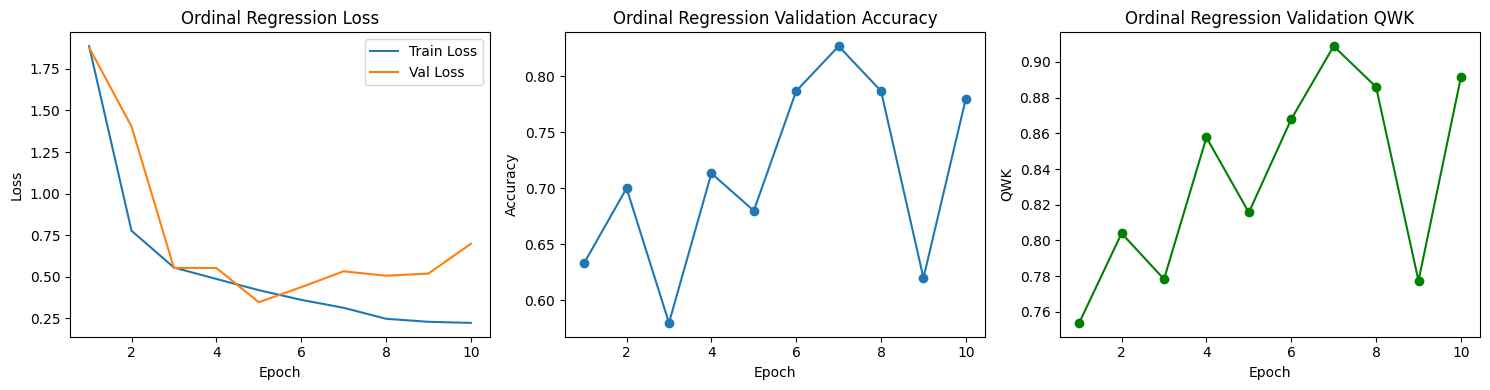

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["tr_loss"]) + 1)

    plt.figure(figsize=(15, 4))

    # --- Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["tr_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["val_acc"], marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Validation Accuracy")

    # --- QWK ---
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_qwk"], marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("QWK")
    plt.title(f"{title_prefix} Validation QWK")

    plt.tight_layout()
    plt.show()

# Exemple d'appel pour l'ordinal regression
plot_history(history_ord, title_prefix="Ordinal Regression")


### 🎯 Validation Probability Collection & Threshold Tuning

This block fine-tunes the decision thresholds to maximize the **Quadratic Weighted Kappa (QWK)** score for an ordinal classification model.

- **`collect_val_probs`**: Collects sigmoid probabilities and true labels from the validation set.
- **Load Best Model**: Restores the best saved model before threshold tuning.
- **`qwk_for_thresholds`**: Computes QWK for a given set of thresholds.
- **Grid Search**: Explores multiple threshold combinations around 0.5 to find the optimal set.
- **Result**: Outputs the best QWK score and tuned thresholds for later use.


In [ ]:
@torch.no_grad()
def collect_val_probs(model, loader):
    """Return stacked sigmoid probs for val (N,4) and true labels (N,)"""
    model.eval()
    probs_list, labels_list = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_list.append(probs)
        labels_list.append(labels.numpy())
    return np.vstack(probs_list), np.concatenate(labels_list)

from itertools import product
import numpy as np

# Load best model before tuning
model_ord.load_state_dict(torch.load(best_path_ord, map_location=device))
model_ord.to(device).eval()

val_probs, val_gts = collect_val_probs(model_ord, val_ld)

def qwk_for_thresholds(probs, gts, taus):
    preds = (probs > np.array(taus)[None, :]).sum(axis=1)
    return cohen_kappa_score(gts, preds, weights="quadratic")

# Small grid search around 0.5
grid = [0.40, 0.45, 0.50, 0.55, 0.60]
best_tau, best_qwk = None, -1.0
for taus in product(grid, repeat=NUM_THRESHOLDS):
    q = qwk_for_thresholds(val_probs, val_gts, taus)
    if q > best_qwk:
        best_qwk, best_tau = q, taus

print("Best val QWK with tuned thresholds:", best_qwk, "taus:", best_tau)
tau_tuned = torch.tensor(best_tau, device=device, dtype=torch.float32)


Best val QWK with tuned thresholds: 0.9157156057238469 taus: (0.4, 0.4, 0.6, 0.55)


### ✅ Evaluation with Tuned Thresholds

This block evaluates the ordinal classification model using the **optimized thresholds** found during tuning:

- **Validation Set**: Computes loss, accuracy, and QWK with tuned thresholds.
- **Test Set**: Performs the same evaluation on the test data to measure final performance.
- **Output**: Displays results for both validation and test sets in a clear, comparable format.


In [ ]:
# Validation with tuned thresholds
val_loss_t, val_acc_t, val_qwk_t = evaluate_ord(model_ord, val_ld, tau_vec=tau_tuned)
print(f"[Val tuned] loss={val_loss_t:.4f} | acc={val_acc_t:.4f} | QWK={val_qwk_t:.4f}")

# Test set
test_loss_o, test_acc_o, test_qwk_o = evaluate_ord(model_ord, test_ld, tau_vec=tau_tuned)
print(f"[Test tuned] loss={test_loss_o:.4f} | acc={test_acc_o:.4f} | QWK={test_qwk_o:.4f}")


[Val tuned] loss=0.5335 | acc=0.8400 | QWK=0.9157


[Test tuned] loss=0.4783 | acc=0.7467 | QWK=0.8702


### Ordinal Regression – Test Results

The model achieved the following metrics on the test set:
- **Loss** = 0.4783  
- **Accuracy** = 0.7467  
- **Quadratic Weighted Kappa (QWK)** = 0.8702  

Compared to the baseline (standard classification), the QWK score has slightly improved.  
This suggests that the ordinal regression head helped the model better capture the ordered nature of the DR severity levels.  
While accuracy is slightly lower, QWK is the more relevant metric for ordinal tasks such as diabetic retinopathy grading.  
This indicates fewer “catastrophic” misclassifications (e.g., predicting class 0 instead of class 4).
